1. 2d rgb에서 yolo 진행
2. Depth에 yolo에서 얻은 ROI 적용
3. Camera intrinsic Load
4. ROI depth -> 3d PCD 진행 
5. 3d ROI PCD로부터 각 픽셀에 대한 Surface normal 수행 
6. PCA 수행하여 주요 축 추출
7. 법선과 PCA축을 통해 좌표계 구성
8. 회전행렬을 통해 RPY변환

In [2]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

import sys
sys.path.append(os.path.abspath("/home/ros/llm_robot"))
from utils.pixel_to_cam_coords import detect_objects
from utils.camera import load_intrinsics, capture_d455_images
from utils.cam_to_base import cam2base, euler_to_rotation_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [171]:
import time
from pymycobot import MyCobot280

SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200

mc = MyCobot280(SERIAL_PORT, BAUD_RATE)

In [177]:
mc.release_all_servos()
input("Press Enter to continue...")
mc.power_on()
mc.get_coords()

[35.9, -8.9, 252.9, 2.79, -72.04, -43.89]

### 1. 2D RGB에서 YOLO 수행하여 ROI 가져오기

In [380]:
# 평행
c_path = "/home/ros/llm_robot/data/captures/color/2025-08-04_14-16-14.jpg"
d_path = "/home/ros/llm_robot/data/captures/depth/2025-08-04_14-16-14.npy"
intr_path = "/home/ros/llm_robot/data/captures/intrinsics/2025-08-04_14-16-14.json"
ee2cam_path = "/home/ros/llm_robot/data/Calibration/Eye-in-Hand2/optimized_cam2ee_icp_point.json"

camera_matrix, dist_coeffs = load_intrinsics(intr_path)

In [180]:
# c_path, d_path, intr_path = capture_d455_images()
# coords = mc.get_coords()
# MODEL_DIR = "/home/ros/llm_robot/yolo/yolo11_seg_cube_best.pt"
# model = YOLO(MODEL_DIR)
# model(c_path)

In [382]:
img = cv2.imread(c_path)

camera_matrix, dist_coeffs = load_intrinsics(intr_path)
result = detect_objects(c_path, d_path, ["cube"], camera_matrix, dist_coeffs, MODEL_DIR)


image 1/1 /home/ros/llm_robot/data/captures/color/2025-08-04_14-16-14.jpg: 384x640 1 cube, 7.2ms
Speed: 0.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

📦 추출된 객체 정보
cube        z=0.367 m  cam=(-0.021, -0.036, 0.367)


In [384]:
# bbox 추출 (yolo 수행 시 pytorch tensor 형식이 GPU 상에 올라가 있는 경우가 많기 때문에, cpu로 옮겨줌.)
boxes = result[0]["bbox"]
x1, y1, x2, y2 = boxes
print(x1, y1, x2, y2)

378 177 428 232


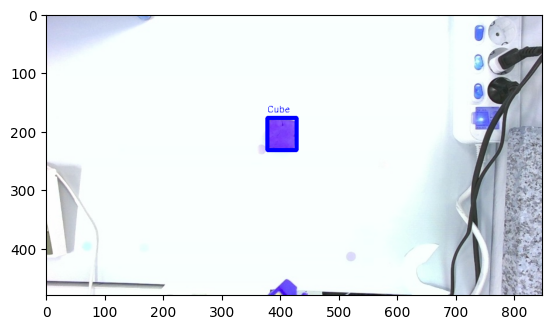

In [385]:
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)
cv2.putText(img, f'Cube', (x1, y1 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
plt.imshow(img);

# 2.Depthmap ROI 생성

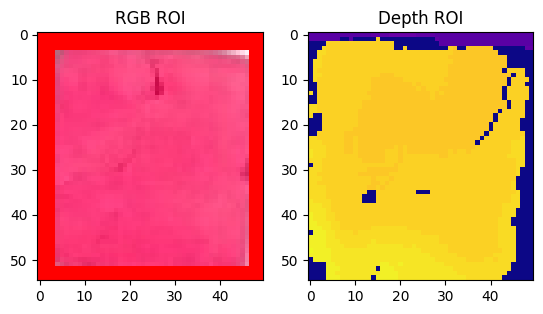

In [386]:
# RGB와 Depth 둘 다 crop해서 시각화 비교
depth = np.load(d_path)
roi_rgb = img[y1:y2, x1:x2] 
roi_depth = depth[y1:y2, x1:x2]
# roi_depth = np.nan_to_num(roi_depth, nan=0.0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(roi_rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB ROI")

plt.subplot(1, 2, 2)
plt.imshow(roi_depth*1000,cmap="plasma")
plt.title("Depth ROI")
plt.show()


In [387]:
fx = camera_matrix[0][0]    # 수평 초점 거리
fy = camera_matrix[1][1]    # 수직 초점 거리
ppx = camera_matrix[0][2]    # center x
ppy = camera_matrix[1][2]    # center y

print(fx, fy, ppx, ppy)

425.2579 424.6796 427.1854 245.99588


In [388]:
depth.shape[1], depth.shape[0]

(848, 480)

In [ ]:
roi_ppx = ppx - x1
roi_ppy = ppy - y1

roi_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=roi_depth.shape[1],
    height=roi_depth.shape[0],
    fx=fx,
    fy=fy,
    cx=roi_ppx,
    cy=roi_ppy
)

## 3. ROI Depth -> PointCloud

In [ ]:
depth_contig = np.ascontiguousarray(roi_depth)
depth_o3d = o3d.geometry.Image(depth_contig)

# depth_o3d = o3d.geometry.Image(roi_depth)

dummy_gray = np.ones_like(roi_depth, dtype=np.uint8) * 128
dummy_rgb = np.stack([dummy_gray]*3, axis=2) 
dummy_color = o3d.geometry.Image(dummy_rgb)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    dummy_color,
    depth_o3d,
    depth_scale=1000,
    depth_trunc = 2.0,
    convert_rgb_to_intensity = False
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd,
    roi_intrinsic
)

# # 좌표계 맞춤 (Open3D 시각화 기준)
# pcd.transform([[1, 0, 0, 0],
#                [0, -1, 0, 0],
#                [0, 0, -1, 0],
#                [0, 0, 0, 1]])

# # 시각화
# o3d.visualization.draw_geometries([pcd],
#                                   window_name = "1. Raw ROI PCD")


In [495]:
plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.005,
    ransac_n=3,
    num_iterations=1000
)

pcd = pcd.select_by_index(inliers)

o3d.visualization.draw_geometries([pcd], window_name = "2. Segmented PCD")

# 4. 각 포인트에 대해 Surface Normal 추정

In [481]:
# 3d ROI PCD로부터 각 픽셀에 대한 Surface normal 수행
pcd.estimate_normals(search_param = o3d.geometry.KDTreeSearchParamKNN(knn=30))
pcd.normalize_normals()

# 시각화 (옵션)
# o3d.visualization.draw_geometries(
#     [pcd],
#     window_name="1. Normals on PCD",
#     point_show_normal=True
# )

PointCloud with 2339 points.

In [483]:
# 평균 법선 방향 계산 
normals = np.asarray(pcd.normals)         # (N,3) 배열
avg_normal = normals.mean(axis=0)         # 평균 법선 벡터
avg_normal /= np.linalg.norm(avg_normal)  # 단위 벡터로 정규화

# PCD의 중심점(centroid) 계산
points = np.asarray(pcd.points)
centroid = points.mean(axis=0)

# 평균 법선을 시각화할 화살표(mesh) 생성
# arrow = o3d.geometry.TriangleMesh.create_arrow(
#     cylinder_radius=0.0005, cone_radius=0.001,
#     cylinder_height=0.05, cone_height=0.002,
# )

# 기본 z축([0,0,1]) → avg_normal 회전변환
z_axis = np.array([0, 0, 1])
axis = np.cross(z_axis, avg_normal)          # 회전축
axis_norm = np.linalg.norm(axis)
if axis_norm < 1e-6:
    rot_mat = np.eye(3)
else:
    axis /= axis_norm
    angle = np.arccos(np.dot(z_axis, avg_normal))
    rot_mat = Rotation.from_rotvec(axis * angle).as_matrix()
    
# arrow.rotate(rot_mat, center=(0,0,0))       # 화살표를 avg_normal 방향으로 회전
# arrow.translate(centroid)                    # PCD 중심에 화살표 위치시킴

# # PCD + 평균 법선 화살표 시각화
# o3d.visualization.draw_geometries(
#     [pcd, arrow],
#     window_name="2. Average Normal Visualization"
# )

# PCA 추가

In [484]:
# 1) 원래 포인트클라우드(points) → centroid 원점 이동
points_centered = points - centroid  # shape (N,3)

# 2) 법선 정렬 Δ회전(rot_mat)의 역행렬로 포인트 '보정'
#    → avg_normal이 Z축으로 정렬된 상태로 변환
R_align_inv = rot_mat.T
points_aligned = (R_align_inv.dot(points_centered.T)).T  # shape (N,3)

# 3) XY평면(그리퍼 오픈 평면)으로 투영
proj2d = points_aligned[:, :2]  # (x, y) 좌표만 뽑음

# 4) 2D PCA로 공분산행렬·고유벡터 계산
cov = np.cov(proj2d.T)                     # 2×2
eigs, vecs = np.linalg.eigh(cov)           # 고유값 오름차순
# vecs[:, -1] 은 장축, vecs[:, -2] 는 단축(minor axis)
minor_axis = vecs[:, -2]

# 5) 단축 방향(그리퍼 개방 방향) 기준 Yaw 계산
yaw_pca = np.degrees(np.arctan2(minor_axis[1], minor_axis[0]))
yaw_pca

np.float64(179.88588821195802)

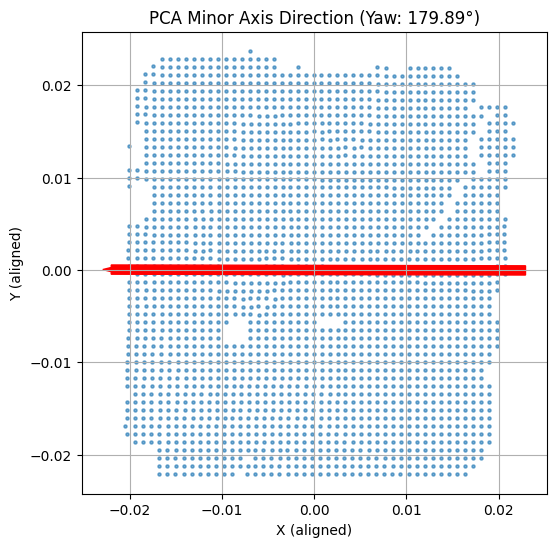

In [485]:
# 1) 투영된 점들의 중심 계산
centroid_2d = proj2d.mean(axis=0)

# 2) 화살표 길이 설정 (투영 범위의 절반)
length = max(np.ptp(proj2d, axis=0)) * 0.5  # np.ptp 사용
dx, dy = minor_axis * length

# 3) 플롯 그리기
plt.figure(figsize=(6,6))
plt.scatter(proj2d[:, 0], proj2d[:, 1], s=5, alpha=0.6)
plt.arrow(
    centroid_2d[0] - dx, centroid_2d[1] - dy,
    2 * dx, 2 * dy,
    head_width=0.02 * length,
    head_length=0.04 * length,
    length_includes_head=True,
    color='r'
)
plt.title(f"PCA Minor Axis Direction (Yaw: {yaw_pca:.2f}°)")
plt.xlabel("X (aligned)")
plt.ylabel("Y (aligned)")
plt.axis('equal')
plt.grid(True)
plt.show()

# 5. RPY(roll, pitch, yaw) 분해
- 카메라 기준으로 계산된 회전

In [486]:
rp_cam = Rotation.from_matrix(rot_mat).as_euler('xyz', degrees=True)
roll, pitch, yaw= rp_cam
print(f"Computed Grasp Orientation:\n  Roll: {roll:.2f}°\n  Pitch: {pitch:.2f}°\n  Yaw: {yaw:.2f}°")

Computed Grasp Orientation:
  Roll: 2.92°
  Pitch: -1.22°
  Yaw: -0.03°


# 6. Cam2ee 변환

In [490]:
ee2cam_path = "/home/ros/llm_robot/data/Calibration/Eye-in-Hand2/optimized_cam2ee_icp_point.json"
# 베이스 기준 절대 자세 제어
with open(ee2cam_path, "r") as f:
    data = json.load(f)

R_cam2ee = np.array(data["R_cam2ee"])
R_ee2cam = np.linalg.inv(R_cam2ee)

# 현재 로봇 포즈 가져오기 (coords 사용)
coords = [81.6, -67.5, 299.4, -171.96, -3.71, -94.06]
position = np.array(coords[0:3]).reshape(3, 1) / 1000.0  # mm → m
rx, ry, rz = np.radians(coords[3:6])

R_base2ee = euler_to_rotation_matrix(rx, ry, rz)
R_base2cam_cur = R_base2ee.dot(R_ee2cam)

R_base2ee_norm = R_base2cam_cur.dot(rot_mat).dot(R_cam2ee)
# --- 2) 여기서 Roll·Pitch만 추출 (Yaw는 무시) ---
roll_norm, pitch_norm, _ = Rotation.from_matrix(R_base2ee_norm).as_euler('xyz', degrees=True)

# --- 3) PCA로 구한 카메라 프레임 Yaw를 그대로 최종 Yaw로 사용 ---
#    (base 기준 변환 결과와 관계없이)
yaw_des = yaw_pca 

# --- 4) 최종 RPY 리스트 생성 (소수점 1자리) ---
final_rpy = [round(roll_norm, 1), round(pitch_norm, 1), round(yaw_des, 1)]

print(final_rpy)

[np.float64(-169.0), np.float64(-2.6), np.float64(179.9)]


# 실험

In [159]:
cam_xyz = result[0]["cam_xyz"]
base_xyz = cam2base(cam_xyz,coords, ee2cam_path, ee2cam = False)
base_xyz[2] = 120

로봇 base 기준 위치: [     189.92       136.7      -212.6] (mm)


In [496]:
combined = np.hstack((base_xyz, final_rpy))
combined_list = [round(float(x), 1) for x in combined]
combined_list

[189.9, 136.7, 120.0, -169.0, -2.6, 179.9]

In [75]:
mc.set_gripper_value(50, 50)
mc.send_coords(combined_list, 50, 1)
time.sleep(2)
# mc.set_gripper_state(1, 50)

# 실험2: 대각선

In [3]:
# 대각선
c_path = "/home/ros/llm_robot/data/captures/color/2025-08-04_15-27-57.jpg"
d_path = "/home/ros/llm_robot/data/captures/depth/2025-08-04_15-27-57.npy"
intr_path = "/home/ros/llm_robot/data/captures/intrinsics/2025-08-04_15-27-57.json"
ee2cam_path = "/home/ros/llm_robot/data/Calibration/Eye-in-Hand2/optimized_cam2ee_icp_point.json"
MODEL_DIR = "/home/ros/llm_robot/yolo/yolo11_seg_cube_best.pt"

camera_matrix, dist_coeffs = load_intrinsics(intr_path)

In [5]:
img = cv2.imread(c_path)

camera_matrix, dist_coeffs = load_intrinsics(intr_path)
result = detect_objects(c_path, d_path, ["cube"], camera_matrix, dist_coeffs, MODEL_DIR)

x1, y1, x2, y2 = result[0]["bbox"]

fx = camera_matrix[0][0]    # 수평 초점 거리
fy = camera_matrix[1][1]    # 수직 초점 거리
ppx = camera_matrix[0][2]    # center x
ppy = camera_matrix[1][2]    # center y

depth = np.load(d_path)
roi_rgb = img[y1:y2, x1:x2] 
roi_depth = depth[y1:y2, x1:x2]

roi_ppx = ppx - x1
roi_ppy = ppy - y1

roi_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=roi_depth.shape[1],
    height=roi_depth.shape[0],
    fx=fx,
    fy=fy,
    cx=roi_ppx,
    cy=roi_ppy
)

depth_contig = np.ascontiguousarray(roi_depth)
depth_o3d = o3d.geometry.Image(depth_contig)

# depth_o3d = o3d.geometry.Image(roi_depth)

dummy_gray = np.ones_like(roi_depth, dtype=np.uint8) * 128
dummy_rgb = np.stack([dummy_gray]*3, axis=2) 
dummy_color = o3d.geometry.Image(dummy_rgb)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    dummy_color,
    depth_o3d,
    depth_scale=1000,
    depth_trunc = 2.0,
    convert_rgb_to_intensity = False
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd,
    roi_intrinsic
)

plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.005,
    ransac_n=3,
    num_iterations=1000
)

pcd = pcd.select_by_index(inliers)
pcd.estimate_normals(search_param = o3d.geometry.KDTreeSearchParamKNN(knn=30))
pcd.normalize_normals()

# 평균 법선 방향 계산 
normals = np.asarray(pcd.normals)         # (N,3) 배열
avg_normal = normals.mean(axis=0)         # 평균 법선 벡터
avg_normal /= np.linalg.norm(avg_normal)  # 단위 벡터로 정규화

# PCD의 중심점(centroid) 계산
points = np.asarray(pcd.points)

# 기본 z축([0,0,1]) → avg_normal 회전변환
z_axis = np.array([0, 0, 1])
axis = np.cross(z_axis, avg_normal)          # 회전축
axis_norm = np.linalg.norm(axis)
if axis_norm < 1e-6:
    rot_mat = np.eye(3)
else:
    axis /= axis_norm
    angle = np.arccos(np.dot(z_axis, avg_normal))
    rot_mat = Rotation.from_rotvec(axis * angle).as_matrix()


image 1/1 /home/ros/llm_robot/data/captures/color/2025-08-04_15-27-57.jpg: 384x640 1 cube, 7.7ms
Speed: 1.0ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

📦 추출된 객체 정보
cube        z=0.355 m  cam=(-0.196, -0.046, 0.355)


In [9]:
# 1) 원래 포인트클라우드(points) → centroid 원점 이동
centroid = points.mean(axis=0)
points_centered = points - centroid  # shape (N,3)

# 2) 법선 정렬 Δ회전(rot_mat)의 역행렬로 포인트 '보정'
#    → avg_normal이 Z축으로 정렬된 상태로 변환
R_align_inv = rot_mat.T
points_aligned = (R_align_inv.dot(points_centered.T)).T  # shape (N,3)

# 3) XY평면(그리퍼 오픈 평면)으로 투영
proj2d = points_aligned[:, :2]  # (x, y) 좌표만 뽑음

# 4) 2D PCA로 공분산행렬·고유벡터 계산
cov = np.cov(proj2d.T)                     # 2×2
eigs, vecs = np.linalg.eigh(cov)           # 고유값 오름차순
# vecs[:, -1] 은 장축, vecs[:, -2] 는 단축(minor axis)
minor_axis = vecs[:, -2]

# 5) 단축 방향(그리퍼 개방 방향) 기준 Yaw 계산
yaw_pca = np.degrees(np.arctan2(minor_axis[1], minor_axis[0]))

In [10]:
# 베이스 기준 절대 자세 제어
with open(ee2cam_path, "r") as f:
    data = json.load(f)

R_cam2ee = np.array(data["R_cam2ee"])
R_ee2cam = np.linalg.inv(R_cam2ee)

# 현재 로봇 포즈 가져오기 (coords 사용)
coords = [81.6, -67.5, 299.4, -171.96, -3.71, -94.06]
position = np.array(coords[0:3]).reshape(3, 1) / 1000.0  # mm → m
rx, ry, rz = np.radians(coords[3:6])

R_base2ee = euler_to_rotation_matrix(rx, ry, rz)
R_base2cam_cur = R_base2ee.dot(R_ee2cam)

R_base2ee_norm = R_base2cam_cur.dot(rot_mat).dot(R_cam2ee)
# --- 2) 여기서 Roll·Pitch만 추출 (Yaw는 무시) ---
roll_norm, pitch_norm, yaw_norm = Rotation.from_matrix(R_base2ee_norm).as_euler('xyz', degrees=True)

# --- 4) 최종 RPY 리스트 생성 (소수점 1자리) ---
final_rpy = [round(roll_norm, 1), round(pitch_norm, 1), round(yaw_pca, 1)]

print(final_rpy)

[np.float64(-167.2), np.float64(-0.2), np.float64(-53.4)]


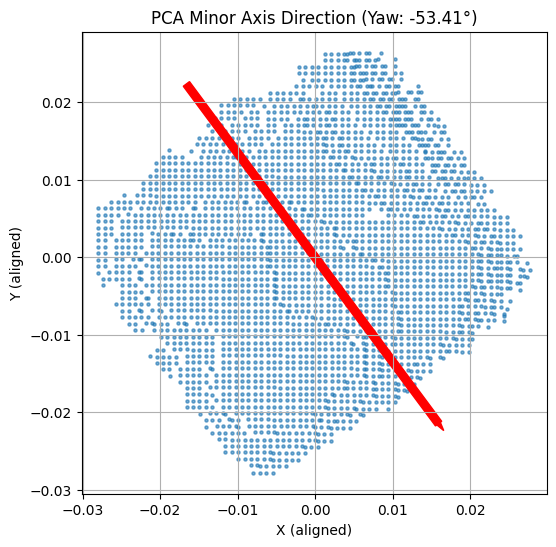

In [11]:
# 1) 투영된 점들의 중심 계산
centroid_2d = proj2d.mean(axis=0)

# 2) 화살표 길이 설정 (투영 범위의 절반)
length = max(np.ptp(proj2d, axis=0)) * 0.5  # np.ptp 사용
dx, dy = minor_axis * length

# 3) 플롯 그리기
plt.figure(figsize=(6,6))
plt.scatter(proj2d[:, 0], proj2d[:, 1], s=5, alpha=0.6)
plt.arrow(
    centroid_2d[0] - dx, centroid_2d[1] - dy,
    2 * dx, 2 * dy,
    head_width=0.02 * length,
    head_length=0.04 * length,
    length_includes_head=True,
    color='r'
)
plt.title(f"PCA Minor Axis Direction (Yaw: {yaw_pca:.2f}°)")
plt.xlabel("X (aligned)")
plt.ylabel("Y (aligned)")
plt.axis('equal')
plt.grid(True)
plt.show()